I declare that this submission is my own work, and that I did not use any pretrained model or code that I did not explicitly cite.


In [8]:
# import libraries

# general libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# libraries for traing, testing, evaluating model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



## Data Inspection


In [9]:
# Load data
data = np.load('dataset_dev_3000.npz')

# Explore keys
print("Keys:", data.files)

# Extract arrays
X = data['X']
y = data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)


Keys: ['X', 'y']
X shape: (3000, 32, 32)
y shape: (3000, 3)


In [10]:
# Count number of samples per class
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")


Class 0.0: 387 samples
Class 0.00026430911384522915: 1 samples
Class 0.0012721653329208493: 1 samples
Class 0.001568699604831636: 1 samples
Class 0.001762773492373526: 1 samples
Class 0.0018284324323758483: 1 samples
Class 0.0019072487484663725: 1 samples
Class 0.0020356904715299606: 1 samples
Class 0.0021006499882787466: 1 samples
Class 0.0026393872685730457: 1 samples
Class 0.003119604429230094: 1 samples
Class 0.0033321119844913483: 1 samples
Class 0.0034062291961163282: 1 samples
Class 0.0035183411091566086: 1 samples
Class 0.003814652096480131: 1 samples
Class 0.003852665890008211: 1 samples
Class 0.003922072239220142: 1 samples
Class 0.004057707265019417: 1 samples
Class 0.004159008618444204: 1 samples
Class 0.004307989031076431: 1 samples
Class 0.0043214308097958565: 1 samples
Class 0.0043290406465530396: 1 samples
Class 0.0044805440120399: 1 samples
Class 0.005482145119458437: 1 samples
Class 0.00564561178907752: 1 samples
Class 0.005840257741510868: 1 samples
Class 0.005890033

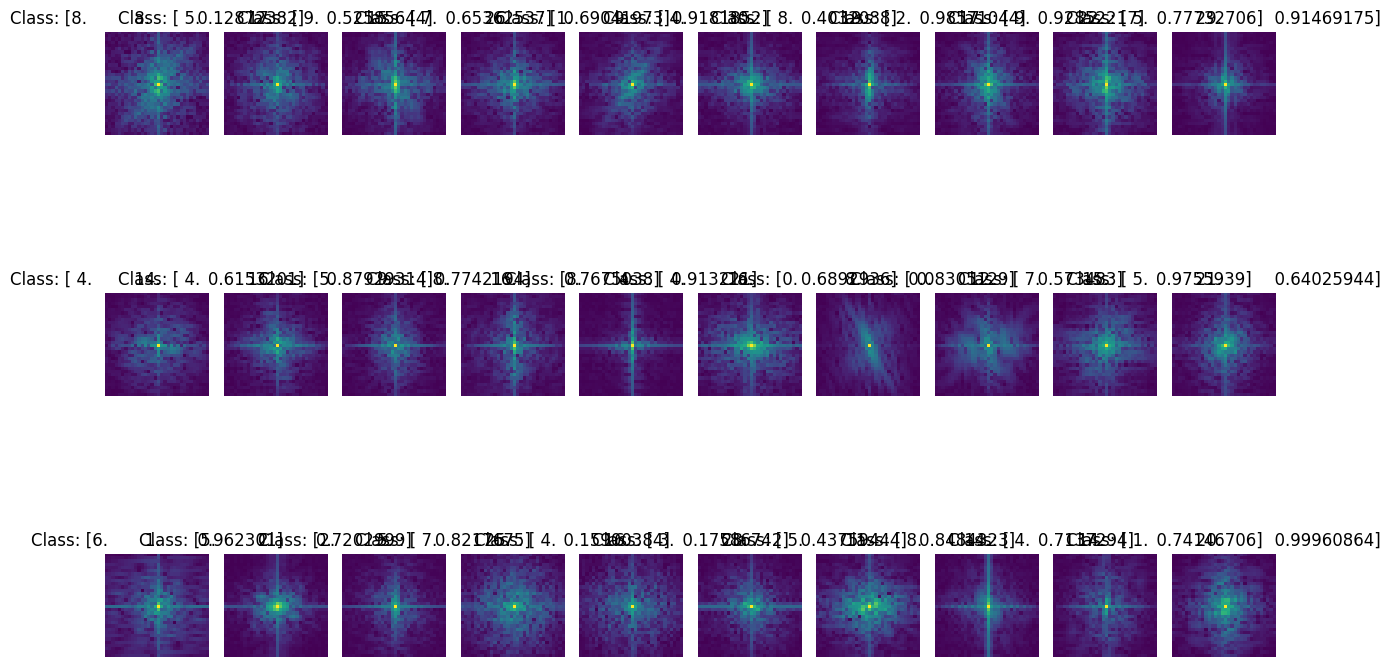

In [11]:
num_images = 30
rows = 3
cols = 10 

plt.figure(figsize=(12, 9))

# Pick 10 random indices
random_indices = np.random.choice(len(X), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Class: {y[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing


In [12]:
# Normalize images
X = X.astype('float32') / 255.0

# Convert (16000, 32, 32) → (16000, 32, 32, 1)
X = X[..., np.newaxis]

y1 = y[:,0]              # Target A (0-9)
y2 = y[:,1]              # Target B (0-31)
y3 = y[:,2].astype('float32')  # Target C (regression)


In [13]:
print("y1 range:", y1.min(), "to", y1.max())
print("y2 range:", y2.min(), "to", y2.max())
print("y3 range:", y3.min(), "to", y3.max())


y1 range: 0.0 to 9.0
y2 range: 0.0 to 31.0
y3 range: 0.0002643091 to 0.99960864


In [14]:
# Train test split at 80/20 ratio
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y1, y2, y3,
    test_size=0.2,
    random_state=42
)
print(X_train.shape, y1_train.shape, y2_train.shape, y3_train.shape)
print(X_test.shape, y1_test.shape, y2_test.shape, y3_test.shape)

(2400, 32, 32, 1) (2400,) (2400,) (2400,)
(600, 32, 32, 1) (600,) (600,) (600,)


## Data Augmentation


In [15]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split(
    X_train, y1_train, y2_train, y3_train, test_size=0.2, random_state=42
)

# Create Dataset from NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        X_train,
        {
            "output_1": y1_train,
            "output_2": y2_train,
            "output_3": y3_train
        }
    )
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        X_val,
        {
            "output_1": y1_val,
            "output_2": y2_val,
            "output_3": y3_val
        }
    )
)
# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),
    layers.RandomZoom(0.1),
])

def augment(x, y):
    x = data_augmentation(x)
    return x, y

train_ds = train_ds.shuffle(1000).map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## Architecture


In [16]:
from tensorflow.keras import layers

class LeNet(tf.keras.Model):
    def __init__(self, num_classes=(10,32,1)):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv1 = layers.Conv2D(6, kernel_size=5, activation='tanh')
        self.pool1 = layers.AveragePooling2D(pool_size=2, strides=2)

        self.conv2 = layers.Conv2D(16, kernel_size=5, activation='tanh')
        self.pool2 = layers.AveragePooling2D(pool_size=2, strides=2)

        # Fully connected layers
        self.flatten = layers.Flatten()
        
        self.fc1 = layers.Dense(120, activation='tanh')
        self.fc2 = layers.Dense(84, activation='tanh')
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')

        self.fc1_2 = layers.Dense(120, activation='tanh')
        self.fc2_2 = layers.Dense(84, activation='tanh')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')

        self.fc1_3 = layers.Dense(120, activation='tanh')
        self.fc2_3 = layers.Dense(84, activation='tanh')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='linear')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x_1 = self.fc1(x)
        x_1 = self.fc2(x_1)
        x_1 = self.output_layer_1(x_1)

        x_2 = self.fc1_2(x)
        x_2 = self.fc2_2(x_2)
        x_2 = self.output_layer_2(x_2)

        x_3 = self.fc1_3(x)
        x_3 = self.fc2_3(x_3)
        x_3 = self.output_layer_3(x_3)

        return {
            "output_1": x_1,  # 10-class classification
            "output_2": x_2,  # 32-class classification
            "output_3": x_3   # regression
        }




In [17]:
from tensorflow.keras import layers, Model

class AlexNet(Model):
    def __init__(self, input_shape = (32, 32, 1), num_classes=(10,32,1)):
        super(AlexNet, self).__init__()

        # Layer 1
        self.conv1 = layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape)
        self.relu1 = layers.Activation('relu')
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn1 = layers.BatchNormalization()

        # Layer 2
        self.conv2 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu2 = layers.Activation('relu')
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn2 = layers.BatchNormalization()

        # Layer 3
        self.conv3 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu3 = layers.Activation('relu')

        # Layer 4
        self.conv4 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu4 = layers.Activation('relu')

        # Layer 5
        self.conv5 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu5 = layers.Activation('relu')
        self.pool5 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        # Fully connected layers
        self.flatten = layers.Flatten()

        self.fc1_1 = layers.Dense(512)
        self.relu_fc1_1 = layers.Activation('relu')
        self.dropout1_1 = layers.Dropout(0.5)

        self.fc2_1 = layers.Dense(256)
        self.relu_fc2_1 = layers.Activation('relu')
        self.dropout2_1 = layers.Dropout(0.5)

        self.fc1_2 = layers.Dense(512)
        self.relu_fc1_2 = layers.Activation('relu')
        self.dropout1_2 = layers.Dropout(0.5)

        self.fc2_2 = layers.Dense(256)
        self.relu_fc2_2 = layers.Activation('relu')
        self.dropout2_2 = layers.Dropout(0.5)

        self.fc1_3 = layers.Dense(512)
        self.relu_fc1_3 = layers.Activation('relu')
        self.dropout1_3 = layers.Dropout(0.5)

        self.fc2_3 = layers.Dense(256)
        self.relu_fc2_3 = layers.Activation('relu')
        self.dropout2_3 = layers.Dropout(0.5)


        # Output layer
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='linear')

    def call(self, x, training=False):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Flatten
        x = self.flatten(x)

        # First path
        x_1 = self.fc1_1(x)
        x_1 = self.relu_fc1_1(x_1)
        x_1 = self.dropout1_1(x_1, training=training)

        x_1 = self.fc2_1(x_1)
        x_1 = self.relu_fc2_1(x_1)
        x_1 = self.dropout2_1(x_1, training=training)
        output_1 = self.output_layer_1(x_1)

        # Second path
        x_2 = self.fc1_2(x)
        x_2 = self.relu_fc1_2(x_2)
        x_2 = self.dropout1_2(x_2, training=training)

        x_2 = self.fc2_2(x_2)
        x_2 = self.relu_fc2_2(x_2)
        x_2 = self.dropout2_2(x_2, training=training)
        output_2 = self.output_layer_2(x_2)

        # Third path
        x_3 = self.fc1_3(x)
        x_3 = self.relu_fc1_3(x_3)
        x_3 = self.dropout1_3(x_3, training=training)

        x_3 = self.fc2_3(x_3)
        x_3 = self.relu_fc2_3(x_3)
        x_3 = self.dropout2_3(x_3, training=training)
        output_3 = self.output_layer_3(x_3)


        # Output
        return {
            "output_1": output_1,  # 10-class classification
            "output_2": output_2,  # 32-class classification
            "output_3": output_3   # regression
        }


In [21]:
optimizer = Adam(learning_rate=0.0001) 

model = LeNet()
model.compile(
    optimizer=optimizer,
    loss={
        "output_1": "sparse_categorical_crossentropy",
        "output_2": "sparse_categorical_crossentropy",
        "output_3": "mse"
    },
    metrics={
        "output_1": ["accuracy"],
        "output_2": ["accuracy"],
        "output_3": ["mse"]
    },
    loss_weights={
        "output_1": 1.0,
        "output_2": 1.0,
        "output_3": 0.1
    }
)

model.build(input_shape=(None, 32, 32, 1))

c:\Users\nguy7155\OneDrive - Rackspace Inc\Desktop\DL\DL-ASM2\DL-ASM2\.venv\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'le_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [22]:
# dummy_input = tf.random.normal((1, 32, 32, 1))
# model(dummy_input)
# model.summary()

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

# # Save the best model based on Target A (first output) validation accuracy
# checkpoint = ModelCheckpoint(
#     filepath='model_s3759957.h5',
#     monitor='val_output_1_accuracy',  # monitor the first output's accuracy
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )


checkpoints = [
    ModelCheckpoint(
        "best_cls10.h5",
        monitor="val_output_1_accuracy",
        mode="max",
        save_best_only=True
    ),
    ModelCheckpoint(
        "best_cls32.h5",
        monitor="val_output_2_accuracy",
        mode="max",
        save_best_only=True
    ),
    ModelCheckpoint(
        "best_reg.h5",
        monitor="val_output_3_mse",
        mode="min",
        save_best_only=True
    )
]



# Training
history = model.fit(
    train_ds,          # tf.data.Dataset for training (X, (y1, y2, y3))
    validation_data=val_ds,  # tf.data.Dataset for validation
    epochs=30,
    verbose=1,
    callbacks=checkpoints
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7964 - output_1_accuracy: 0.1052 - output_1_loss: 2.3026 - output_2_accuracy: 0.0254 - output_2_loss: 3.4658 - output_3_loss: 0.2798 - output_3_mse: 0.2798

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 5.7898 - output_1_accuracy: 0.1063 - output_1_loss: 2.3029 - output_2_accuracy: 0.0245 - output_2_loss: 3.4658 - output_3_loss: 0.2103 - output_3_mse: 0.2103 - val_loss: 5.7780 - val_output_1_accuracy: 0.0979 - val_output_1_loss: 2.3032 - val_output_2_accuracy: 0.0375 - val_output_2_loss: 3.4659 - val_output_3_loss: 0.0887 - val_output_3_mse: 0.0887
Epoch 2/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7744 - output_1_accuracy: 0.1128 - output_1_loss: 2.3018 - output_2_accuracy: 0.0366 - output_2_loss: 3.4641 - output_3_loss: 0.0849 - output_3_mse: 0.0849

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7750 - output_1_accuracy: 0.1052 - output_1_loss: 2.3021 - output_2_accuracy: 0.0359 - output_2_loss: 3.4644 - output_3_loss: 0.0846 - output_3_mse: 0.0846 - val_loss: 5.7785 - val_output_1_accuracy: 0.0979 - val_output_1_loss: 2.3022 - val_output_2_accuracy: 0.0271 - val_output_2_loss: 3.4675 - val_output_3_loss: 0.0879 - val_output_3_mse: 0.0879
Epoch 3/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7713 - output_1_accuracy: 0.1088 - output_1_loss: 2.3009 - output_2_accuracy: 0.0347 - output_2_loss: 3.4618 - output_3_loss: 0.0864 - output_3_mse: 0.0864

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7733 - output_1_accuracy: 0.1057 - output_1_loss: 2.3019 - output_2_accuracy: 0.0380 - output_2_loss: 3.4631 - output_3_loss: 0.0835 - output_3_mse: 0.0835 - val_loss: 5.7796 - val_output_1_accuracy: 0.0979 - val_output_1_loss: 2.3017 - val_output_2_accuracy: 0.0271 - val_output_2_loss: 3.4692 - val_output_3_loss: 0.0872 - val_output_3_mse: 0.0872
Epoch 4/30
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7718 - output_1_accuracy: 0.1179 - output_1_loss: 2.3014 - output_2_accuracy: 0.0319 - output_2_loss: 3.4623 - output_3_loss: 0.0816 - output_3_mse: 0.0816

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7714 - output_1_accuracy: 0.1057 - output_1_loss: 2.3013 - output_2_accuracy: 0.0359 - output_2_loss: 3.4618 - output_3_loss: 0.0825 - output_3_mse: 0.0825 - val_loss: 5.7801 - val_output_1_accuracy: 0.0979 - val_output_1_loss: 2.3013 - val_output_2_accuracy: 0.0271 - val_output_2_loss: 3.4702 - val_output_3_loss: 0.0865 - val_output_3_mse: 0.0865
Epoch 5/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7692 - output_1_accuracy: 0.1098 - output_1_loss: 2.2999 - output_2_accuracy: 0.0380 - output_2_loss: 3.4614 - output_3_loss: 0.0791 - output_3_mse: 0.0791

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7699 - output_1_accuracy: 0.1104 - output_1_loss: 2.3007 - output_2_accuracy: 0.0375 - output_2_loss: 3.4611 - output_3_loss: 0.0811 - output_3_mse: 0.0811 - val_loss: 5.7805 - val_output_1_accuracy: 0.1229 - val_output_1_loss: 2.3001 - val_output_2_accuracy: 0.0271 - val_output_2_loss: 3.4720 - val_output_3_loss: 0.0845 - val_output_3_mse: 0.0845
Epoch 6/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7655 - output_1_accuracy: 0.1273 - output_1_loss: 2.2987 - output_2_accuracy: 0.0401 - output_2_loss: 3.4588 - output_3_loss: 0.0803 - output_3_mse: 0.0803

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7676 - output_1_accuracy: 0.1125 - output_1_loss: 2.2993 - output_2_accuracy: 0.0344 - output_2_loss: 3.4604 - output_3_loss: 0.0786 - output_3_mse: 0.0786 - val_loss: 5.7821 - val_output_1_accuracy: 0.0958 - val_output_1_loss: 2.2995 - val_output_2_accuracy: 0.0292 - val_output_2_loss: 3.4744 - val_output_3_loss: 0.0815 - val_output_3_mse: 0.0815
Epoch 7/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7640 - output_1_accuracy: 0.1313 - output_1_loss: 2.2974 - output_2_accuracy: 0.0380 - output_2_loss: 3.4589 - output_3_loss: 0.0776 - output_3_mse: 0.0776

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7642 - output_1_accuracy: 0.1224 - output_1_loss: 2.2969 - output_2_accuracy: 0.0375 - output_2_loss: 3.4597 - output_3_loss: 0.0752 - output_3_mse: 0.0752 - val_loss: 5.7791 - val_output_1_accuracy: 0.1083 - val_output_1_loss: 2.2963 - val_output_2_accuracy: 0.0250 - val_output_2_loss: 3.4750 - val_output_3_loss: 0.0781 - val_output_3_mse: 0.0781
Epoch 8/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7567 - output_1_accuracy: 0.1250 - output_1_loss: 2.2928 - output_2_accuracy: 0.0346 - output_2_loss: 3.4567 - output_3_loss: 0.0709 - output_3_mse: 0.0709

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7571 - output_1_accuracy: 0.1318 - output_1_loss: 2.2908 - output_2_accuracy: 0.0370 - output_2_loss: 3.4593 - output_3_loss: 0.0701 - output_3_mse: 0.0701 - val_loss: 5.7701 - val_output_1_accuracy: 0.1167 - val_output_1_loss: 2.2875 - val_output_2_accuracy: 0.0250 - val_output_2_loss: 3.4754 - val_output_3_loss: 0.0729 - val_output_3_mse: 0.0729
Epoch 9/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7439 - output_1_accuracy: 0.1494 - output_1_loss: 2.2795 - output_2_accuracy: 0.0422 - output_2_loss: 3.4574 - output_3_loss: 0.0690 - output_3_mse: 0.0690

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7443 - output_1_accuracy: 0.1432 - output_1_loss: 2.2780 - output_2_accuracy: 0.0411 - output_2_loss: 3.4593 - output_3_loss: 0.0693 - output_3_mse: 0.0693 - val_loss: 5.7607 - val_output_1_accuracy: 0.1667 - val_output_1_loss: 2.2778 - val_output_2_accuracy: 0.0271 - val_output_2_loss: 3.4758 - val_output_3_loss: 0.0713 - val_output_3_mse: 0.0713
Epoch 10/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7245 - output_1_accuracy: 0.1665 - output_1_loss: 2.2610 - output_2_accuracy: 0.0410 - output_2_loss: 3.4568 - output_3_loss: 0.0669 - output_3_mse: 0.0669

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7233 - output_1_accuracy: 0.1531 - output_1_loss: 2.2584 - output_2_accuracy: 0.0406 - output_2_loss: 3.4582 - output_3_loss: 0.0668 - output_3_mse: 0.0668 - val_loss: 5.7407 - val_output_1_accuracy: 0.1583 - val_output_1_loss: 2.2588 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4750 - val_output_3_loss: 0.0697 - val_output_3_mse: 0.0697
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7013 - output_1_accuracy: 0.1609 - output_1_loss: 2.2364 - output_2_accuracy: 0.0406 - output_2_loss: 3.4580 - output_3_loss: 0.0688 - output_3_mse: 0.0688 - val_loss: 5.7249 - val_output_1_accuracy: 0.1542 - val_output_1_loss: 2.2422 - val_output_2_accuracy: 0.0333 - val_output_2_loss: 3.4757 - val_output_3_loss: 0.0701 - val_output_3_mse: 0.0701
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6872 - output_1_accuracy: 0.1552 - output_1_loss: 2.2238 - output_2_accuracy: 0.0411 - output_2_loss: 3.4570 - output_3_loss: 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6682 - output_1_accuracy: 0.1656 - output_1_loss: 2.2072 - output_2_accuracy: 0.0474 - output_2_loss: 3.4549 - output_3_loss: 0.0615 - output_3_mse: 0.0615 - val_loss: 5.7144 - val_output_1_accuracy: 0.1729 - val_output_1_loss: 2.2329 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4749 - val_output_3_loss: 0.0659 - val_output_3_mse: 0.0659
Epoch 15/30
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6580 - output_1_accuracy: 0.1726 - output_1_loss: 2.1988 - output_2_accuracy: 0.0573 - output_2_loss: 3.4529 - output_3_loss: 0.0625 - output_3_mse: 0.0625

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6665 - output_1_accuracy: 0.1635 - output_1_loss: 2.2061 - output_2_accuracy: 0.0526 - output_2_loss: 3.4544 - output_3_loss: 0.0600 - output_3_mse: 0.0600 - val_loss: 5.7180 - val_output_1_accuracy: 0.1771 - val_output_1_loss: 2.2361 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4754 - val_output_3_loss: 0.0660 - val_output_3_mse: 0.0660
Epoch 16/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6659 - output_1_accuracy: 0.1732 - output_1_loss: 2.2110 - output_2_accuracy: 0.0514 - output_2_loss: 3.4487 - output_3_loss: 0.0617 - output_3_mse: 0.0617

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6653 - output_1_accuracy: 0.1682 - output_1_loss: 2.2054 - output_2_accuracy: 0.0437 - output_2_loss: 3.4540 - output_3_loss: 0.0587 - output_3_mse: 0.0587 - val_loss: 5.7089 - val_output_1_accuracy: 0.1833 - val_output_1_loss: 2.2292 - val_output_2_accuracy: 0.0333 - val_output_2_loss: 3.4733 - val_output_3_loss: 0.0639 - val_output_3_mse: 0.0639
Epoch 17/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6643 - output_1_accuracy: 0.1653 - output_1_loss: 2.2107 - output_2_accuracy: 0.0480 - output_2_loss: 3.4475 - output_3_loss: 0.0614 - output_3_mse: 0.0614

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6612 - output_1_accuracy: 0.1708 - output_1_loss: 2.2026 - output_2_accuracy: 0.0479 - output_2_loss: 3.4528 - output_3_loss: 0.0583 - output_3_mse: 0.0583 - val_loss: 5.7059 - val_output_1_accuracy: 0.1917 - val_output_1_loss: 2.2260 - val_output_2_accuracy: 0.0354 - val_output_2_loss: 3.4735 - val_output_3_loss: 0.0641 - val_output_3_mse: 0.0641
Epoch 18/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6520 - output_1_accuracy: 0.1805 - output_1_loss: 2.1987 - output_2_accuracy: 0.0500 - output_2_loss: 3.4469 - output_3_loss: 0.0647 - output_3_mse: 0.0647

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6630 - output_1_accuracy: 0.1760 - output_1_loss: 2.2040 - output_2_accuracy: 0.0464 - output_2_loss: 3.4530 - output_3_loss: 0.0595 - output_3_mse: 0.0595 - val_loss: 5.7049 - val_output_1_accuracy: 0.1958 - val_output_1_loss: 2.2255 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4731 - val_output_3_loss: 0.0624 - val_output_3_mse: 0.0624
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6348 - output_1_accuracy: 0.1959 - output_1_loss: 2.1850 - output_2_accuracy: 0.0484 - output_2_loss: 3.4441 - output_3_loss: 0.0565 - output_3_mse: 0.0565

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6554 - output_1_accuracy: 0.1880 - output_1_loss: 2.1986 - output_2_accuracy: 0.0474 - output_2_loss: 3.4512 - output_3_loss: 0.0557 - output_3_mse: 0.0557 - val_loss: 5.7011 - val_output_1_accuracy: 0.1792 - val_output_1_loss: 2.2242 - val_output_2_accuracy: 0.0250 - val_output_2_loss: 3.4707 - val_output_3_loss: 0.0621 - val_output_3_mse: 0.0621
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6451 - output_1_accuracy: 0.1901 - output_1_loss: 2.1883 - output_2_accuracy: 0.0453 - output_2_loss: 3.4512 - output_3_loss: 0.0557 - output_3_mse: 0.0557 - val_loss: 5.6956 - val_output_1_accuracy: 0.1958 - val_output_1_loss: 2.2172 - val_output_2_accuracy: 0.0333 - val_output_2_loss: 3.4721 - val_output_3_loss: 0.0623 - val_output_3_mse: 0.0623
Epoch 21/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6360 - output_1_accuracy: 0.2005 - output_1_loss: 2.1866 - output_2_accuracy: 0.0403 - output_2_loss: 3.4437 - output_3_loss: 0

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6512 - output_1_accuracy: 0.1906 - output_1_loss: 2.1953 - output_2_accuracy: 0.0427 - output_2_loss: 3.4504 - output_3_loss: 0.0553 - output_3_mse: 0.0553 - val_loss: 5.6928 - val_output_1_accuracy: 0.1813 - val_output_1_loss: 2.2142 - val_output_2_accuracy: 0.0333 - val_output_2_loss: 3.4727 - val_output_3_loss: 0.0598 - val_output_3_mse: 0.0598
Epoch 22/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6330 - output_1_accuracy: 0.2133 - output_1_loss: 2.1760 - output_2_accuracy: 0.0453 - output_2_loss: 3.4513 - output_3_loss: 0.0569 - output_3_mse: 0.0569

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6396 - output_1_accuracy: 0.2062 - output_1_loss: 2.1853 - output_2_accuracy: 0.0490 - output_2_loss: 3.4489 - output_3_loss: 0.0546 - output_3_mse: 0.0546 - val_loss: 5.6917 - val_output_1_accuracy: 0.2062 - val_output_1_loss: 2.2137 - val_output_2_accuracy: 0.0354 - val_output_2_loss: 3.4721 - val_output_3_loss: 0.0596 - val_output_3_mse: 0.0596
Epoch 23/30
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6371 - output_1_accuracy: 0.1875 - output_1_loss: 2.1860 - output_2_accuracy: 0.0604 - output_2_loss: 3.4457 - output_3_loss: 0.0547 - output_3_mse: 0.0547

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6329 - output_1_accuracy: 0.1839 - output_1_loss: 2.1794 - output_2_accuracy: 0.0479 - output_2_loss: 3.4480 - output_3_loss: 0.0547 - output_3_mse: 0.0547 - val_loss: 5.6957 - val_output_1_accuracy: 0.1917 - val_output_1_loss: 2.2204 - val_output_2_accuracy: 0.0229 - val_output_2_loss: 3.4694 - val_output_3_loss: 0.0592 - val_output_3_mse: 0.0592
Epoch 24/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6306 - output_1_accuracy: 0.1934 - output_1_loss: 2.1814 - output_2_accuracy: 0.0450 - output_2_loss: 3.4435 - output_3_loss: 0.0570 - output_3_mse: 0.0570

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6233 - output_1_accuracy: 0.1964 - output_1_loss: 2.1698 - output_2_accuracy: 0.0490 - output_2_loss: 3.4482 - output_3_loss: 0.0540 - output_3_mse: 0.0540 - val_loss: 5.6782 - val_output_1_accuracy: 0.1979 - val_output_1_loss: 2.1998 - val_output_2_accuracy: 0.0375 - val_output_2_loss: 3.4725 - val_output_3_loss: 0.0585 - val_output_3_mse: 0.0585
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6104 - output_1_accuracy: 0.2151 - output_1_loss: 2.1581 - output_2_accuracy: 0.0536 - output_2_loss: 3.4469 - output_3_loss: 0.0536 - output_3_mse: 0.0536 - val_loss: 5.6819 - val_output_1_accuracy: 0.1875 - val_output_1_loss: 2.2009 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4752 - val_output_3_loss: 0.0585 - val_output_3_mse: 0.0585
Epoch 26/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6115 - output_1_accuracy: 0.2085 - output_1_loss: 2.1664 - output_2_accuracy: 0.0520 - output_2_loss: 3.4397 - output_3_loss: 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6067 - output_1_accuracy: 0.2099 - output_1_loss: 2.1541 - output_2_accuracy: 0.0500 - output_2_loss: 3.4473 - output_3_loss: 0.0527 - output_3_mse: 0.0527 - val_loss: 5.6926 - val_output_1_accuracy: 0.1729 - val_output_1_loss: 2.2092 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4777 - val_output_3_loss: 0.0581 - val_output_3_mse: 0.0581
Epoch 27/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6070 - output_1_accuracy: 0.2255 - output_1_loss: 2.1564 - output_2_accuracy: 0.0490 - output_2_loss: 3.4452 - output_3_loss: 0.0547 - output_3_mse: 0.0547 - val_loss: 5.6482 - val_output_1_accuracy: 0.2021 - val_output_1_loss: 2.1707 - val_output_2_accuracy: 0.0354 - val_output_2_loss: 3.4715 - val_output_3_loss: 0.0600 - val_output_3_mse: 0.0600
Epoch 28/30
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5859 - output_1_accuracy: 0.2242 - output_1_loss: 2.1383 - output_2_accuracy: 0.0480 - output_2_loss: 3.4424 - output_3_loss: 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5932 - output_1_accuracy: 0.2214 - output_1_loss: 2.1429 - output_2_accuracy: 0.0490 - output_2_loss: 3.4451 - output_3_loss: 0.0528 - output_3_mse: 0.0528 - val_loss: 5.6393 - val_output_1_accuracy: 0.2083 - val_output_1_loss: 2.1631 - val_output_2_accuracy: 0.0292 - val_output_2_loss: 3.4704 - val_output_3_loss: 0.0591 - val_output_3_mse: 0.0591
Epoch 29/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5736 - output_1_accuracy: 0.2233 - output_1_loss: 2.1322 - output_2_accuracy: 0.0520 - output_2_loss: 3.4361 - output_3_loss: 0.0533 - output_3_mse: 0.0533

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5831 - output_1_accuracy: 0.2219 - output_1_loss: 2.1342 - output_2_accuracy: 0.0479 - output_2_loss: 3.4435 - output_3_loss: 0.0541 - output_3_mse: 0.0541 - val_loss: 5.6267 - val_output_1_accuracy: 0.2146 - val_output_1_loss: 2.1490 - val_output_2_accuracy: 0.0312 - val_output_2_loss: 3.4716 - val_output_3_loss: 0.0601 - val_output_3_mse: 0.0601
Epoch 30/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5681 - output_1_accuracy: 0.2219 - output_1_loss: 2.1204 - output_2_accuracy: 0.0469 - output_2_loss: 3.4424 - output_3_loss: 0.0536 - output_3_mse: 0.0536 - val_loss: 5.6250 - val_output_1_accuracy: 0.1979 - val_output_1_loss: 2.1445 - val_output_2_accuracy: 0.0354 - val_output_2_loss: 3.4746 - val_output_3_loss: 0.0585 - val_output_3_mse: 0.0585
